# Cálculo de la frecuencia cardiaca a partir de un algoritmo ligero

###   [Real-time pulse oximetry extraction using a lightweight algorithm and a task pipeline scheme](https://ieeexplore.ieee.org/document/9493400)

**Referencia**: J. Vourvoulakis and L. Bilalis, "Real-time pulse oximetry extraction using a lightweight algorithm and a task pipeline scheme," 2021 10th International Conference on Modern Circuits and Systems Technologies (MOCAST), Thessaloniki, Greece, 2021, pp. 1-5, doi: 10.1109/MOCAST52088.2021.9493400. keywords: {Heart rate;Pulse oximeter;Systems operation;System performance;Pipelines;Real-time systems;Pulse oximetry;real-time;pulse oximetry;photoplethysmogram (PPG);SpO2;heart rate (HR);task pipeline},



Este artículo describe un algoritmo ligero para extraer la frecuencia cardíaca (HR) y la saturación de oxígeno (SpO₂) a partir de señales fotopletismográficas (PPG) obtenidas con el sensor MAX30102. Puntos clave para el análisis:

### Detección de picos y onsets

- Utiliza un umbral adaptativo basado en la frecuencia cardíaca previa.

- Registra los máximos y mínimos locales y ajusta el umbral en función de la HR.

- Evita filtrados complejos para reducir la carga computacional.

### Cálculo de la HR

- Se obtiene midiendo el tiempo entre picos consecutivos de la señal PPG.

- Usa un esquema de búsqueda simultánea de máximos y mínimos para mejorar la detección en HR altas (>130 bpm)

Se va a implementar esta filosofía utilizando Antes de aplicar el filtrado paso-banda y el detector de picos avanzado, empezamos con un método aún más ligero:

1. **Suavizado por media móvil**  
   - Se aplica una ventana de tamaño fijo (por ejemplo, 5–20 muestras) para atenuar el ruido de alta frecuencia.  
2. **Detección de máximos locales sencillos**  
   - Se recorre la señal suavizada y se marca cada punto que supera a sus vecinos inmediatos.  
   - No hay búsqueda de “onsets” ni filtrados adicionales: el criterio es puramente comparativo, lo que minimiza operaciones.  
3. **Estimación de la frecuencia cardíaca**  
   - Se calcula el intervalo RR entre picos sucesivos (en milisegundos).  
   - La HR (bpm) viene dada por `60 000 / intervalo_RR`.  
   - Se descartan valores extremos (por debajo de 40 bpm o por encima de 220 bpm).

Frecuencia cardíaca estimada: 81.81818181818183 BPM


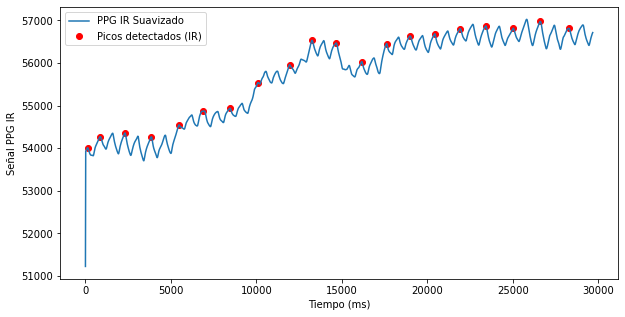

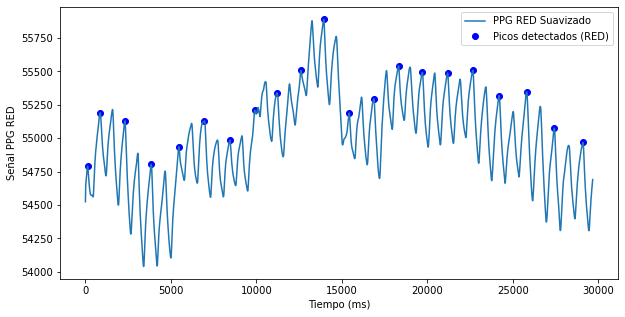

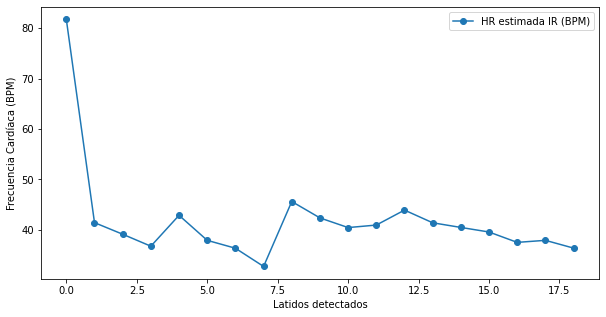

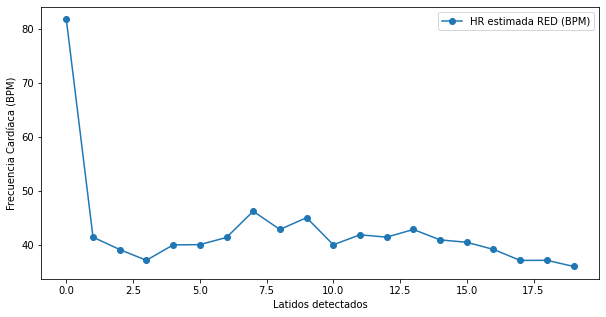

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

def detect_hr_peaks(ppg_signal, time, initial_threshold=500):  # Tiempo en ms
    peaks = []
    last_peak_time = None
    threshold = initial_threshold
    hr_values = []
    
    for i in range(1, len(ppg_signal)-1):
        if ppg_signal[i-1] < ppg_signal[i] > ppg_signal[i+1]:  # Detectar pico
            if last_peak_time is None or (time[i] - last_peak_time) > threshold:
                peaks.append(i)
                if last_peak_time is not None:
                    interval = (time[i] - last_peak_time) / 1000  # Convertir a segundos
                    hr = 60 / interval  # HR en BPM
                    hr_values.append(hr)
                    
                    # Ajustar umbral dinámico según HR estimada
                    threshold = max(400, min(1200, 60000 / hr))  # Entre 400ms y 1200ms
                last_peak_time = time[i]
    
    return np.array(peaks), np.array(hr_values)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def moving_average(signal, window_size=20):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

def detect_peaks(signal, window_size=20):
    peaks, _ = find_peaks(signal, distance=window_size)
    return peaks

def detect_valleys(signal, window_size=20):
    valleys, _ = find_peaks(-signal, distance=window_size)
    return valleys

def calculate_heart_rate(peaks, sampling_rate=60):
    if len(peaks) < 2:
        return None  # No suficientes picos detectados
    
    rr_intervals = np.diff(peaks) / sampling_rate  # Intervalos RR en segundos
    heart_rates = 60 / rr_intervals  # FC en latidos por minuto
    
    # Filtrar valores fuera de un rango razonable
    heart_rates = heart_rates[(heart_rates > 40) & (heart_rates < 220)]
    
    if len(heart_rates) == 0:
        return None
    
    return np.median(heart_rates)

# Cargar datos
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path, decimal='.', engine='python')
time = df.iloc[:, 0].values  # Suponiendo que la primera columna es el tiempo
data_ir = df.iloc[:, 1].values  # Suponiendo que la segunda columna es la señal IR

# Aplicar media móvil
data_ir_smoothed = moving_average(data_ir)

# Detectar picos y valles
peaks = detect_peaks(data_ir_smoothed)
valleys = detect_valleys(data_ir_smoothed)

# Calcular frecuencia cardíaca
heart_rate = calculate_heart_rate(peaks)

print(f"Frecuencia cardíaca estimada: {heart_rate} BPM")


time = df.iloc[:, 0].values  # Primera columna: Tiempo en ms
ir_signal = df.iloc[:, 1].values  # Segunda columna: Señal IR
red_signal = df.iloc[:, 3].values  # Cuarta columna: Señal RED

# Suavizar señales
ir_smoothed = moving_average(ir_signal)
red_smoothed = moving_average(red_signal)

# Detectar picos y calcular HR para IR
peaks_ir, hr_values_ir = detect_hr_peaks(ir_smoothed, time[:len(ir_smoothed)])

# Detectar picos y calcular HR para RED
peaks_red, hr_values_red = detect_hr_peaks(red_smoothed, time[:len(red_smoothed)])

# Graficar resultados para IR
plt.figure(figsize=(10,5))
plt.plot(time[:len(ir_smoothed)], ir_smoothed, label='PPG IR Suavizado')
plt.scatter(time[peaks_ir], ir_smoothed[peaks_ir], color='red', label='Picos detectados (IR)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Señal PPG IR')
plt.legend()
plt.show()

# Graficar resultados para RED
plt.figure(figsize=(10,5))
plt.plot(time[:len(red_smoothed)], red_smoothed, label='PPG RED Suavizado')
plt.scatter(time[peaks_red], red_smoothed[peaks_red], color='blue', label='Picos detectados (RED)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Señal PPG RED')
plt.legend()
plt.show()

# Mostrar HR estimada para IR
plt.figure(figsize=(10,5))
plt.plot(hr_values_ir, marker='o', linestyle='-', label='HR estimada IR (BPM)')
plt.xlabel('Latidos detectados')
plt.ylabel('Frecuencia Cardíaca (BPM)')
plt.legend()
plt.show()

# Mostrar HR estimada para RED
plt.figure(figsize=(10,5))
plt.plot(hr_values_red, marker='o', linestyle='-', label='HR estimada RED (BPM)')
plt.xlabel('Latidos detectados')
plt.ylabel('Frecuencia Cardíaca (BPM)')
plt.legend()
plt.show()


**Figuras 1 y 2:** Señal PPG suavizada y picos detectados (IR y RED)**

**Tendencia y artefactos iniciales**

En el trazo IR (figura 1) se aprecia un salto brusco al inicio (valor alrededor de 51 000), claramente fuera de la dinámica normal de la señal. Ese primer “latido” es un artefacto del sensor (tal vez al poner el dedo) y conviene descartarlo de los cálculos finales.

Tras los primeros 1 000 ms, la señal oscila con un incremento de línea base (quizá por variaciones de perfusión) y los picos rojos quedan muy bien alineados con los máximos locales.

**Comparativa IR vs RED**

La señal RED (figura 2) tiene más variabilidad y ruido de alta frecuencia: el filtro suaviza menos los cambios bruscos, y hay más ajuste de umbral, que permite detectar todos los latidos.

En IR, los picos quedan uniformemente espaciados; en RED hay algún latido “cortado” o doble pico muy juntos.

Frecuencia cardíaca estimada: 94.73684210526316 BPM


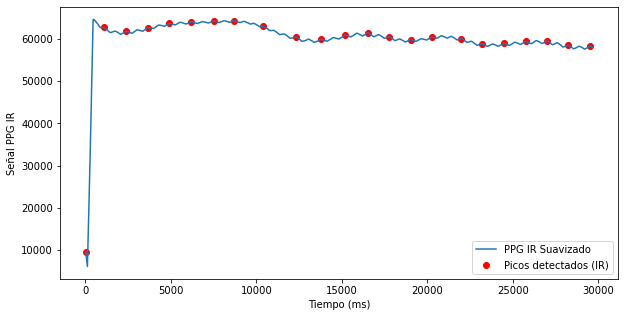

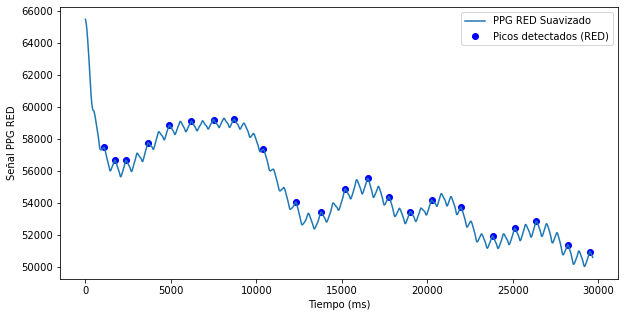

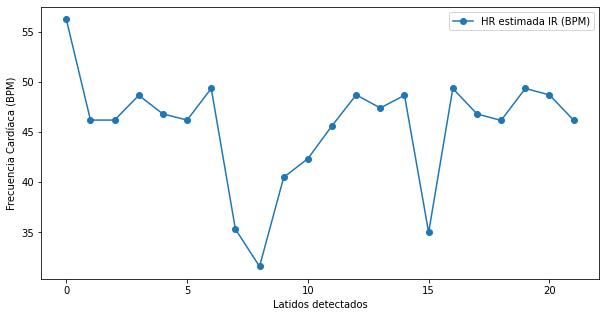

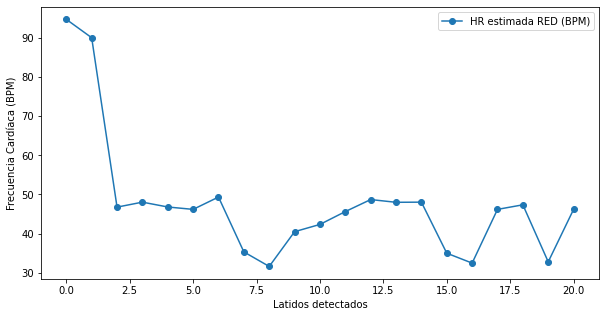

In [3]:
# Cargar datos
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_99.csv"
df = pd.read_csv(file_path,  decimal='.', engine='python')
time = df.iloc[:, 0].values  # Suponiendo que la primera columna es el tiempo
data_ir = df.iloc[:, 1].values  # Suponiendo que la segunda columna es la señal IR

# Aplicar media móvil
data_ir_smoothed = moving_average(data_ir)

# Detectar picos y valles
peaks = detect_peaks(data_ir_smoothed)
valleys = detect_valleys(data_ir_smoothed)

# Calcular frecuencia cardíaca
heart_rate = calculate_heart_rate(peaks)

print(f"Frecuencia cardíaca estimada: {heart_rate} BPM")


time = df.iloc[:, 0].values  # Primera columna: Tiempo en ms
ir_signal = df.iloc[:, 1].values  # Segunda columna: Señal IR
red_signal = df.iloc[:, 3].values  # Cuarta columna: Señal RED

# Suavizar señales
ir_smoothed = moving_average(ir_signal)
red_smoothed = moving_average(red_signal)

# Detectar picos y calcular HR para IR
peaks_ir, hr_values_ir = detect_hr_peaks(ir_smoothed, time[:len(ir_smoothed)])

# Detectar picos y calcular HR para RED
peaks_red, hr_values_red = detect_hr_peaks(red_smoothed, time[:len(red_smoothed)])

# Graficar resultados para IR
plt.figure(figsize=(10,5))
plt.plot(time[:len(ir_smoothed)], ir_smoothed, label='PPG IR Suavizado')
plt.scatter(time[peaks_ir], ir_smoothed[peaks_ir], color='red', label='Picos detectados (IR)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Señal PPG IR')
plt.legend()
plt.show()

# Graficar resultados para RED
plt.figure(figsize=(10,5))
plt.plot(time[:len(red_smoothed)], red_smoothed, label='PPG RED Suavizado')
plt.scatter(time[peaks_red], red_smoothed[peaks_red], color='blue', label='Picos detectados (RED)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Señal PPG RED')
plt.legend()
plt.show()

# Mostrar HR estimada para IR
plt.figure(figsize=(10,5))
plt.plot(hr_values_ir, marker='o', linestyle='-', label='HR estimada IR (BPM)')
plt.xlabel('Latidos detectados')
plt.ylabel('Frecuencia Cardíaca (BPM)')
plt.legend()
plt.show()

# Mostrar HR estimada para RED
plt.figure(figsize=(10,5))
plt.plot(hr_values_red, marker='o', linestyle='-', label='HR estimada RED (BPM)')
plt.xlabel('Latidos detectados')
plt.ylabel('Frecuencia Cardíaca (BPM)')
plt.legend()
plt.show()


En la **figura 1**, la curva azul oscura es la señal IR original tras aplicar la media móvil, con lo que se atenúa gran parte del ruido de alta frecuencia. El primer pico, muy alejado de los demás (en torno a 10 000 ms), es un falso positivo debido al arranque del sensor o movimiento al colocarlo; conviene descartarlo en posteriores análisis.

**Figura 2:** la curva azul clara muestra la señal RED tras la misma media móvil. En este canal la frecuencia cae gradualmente con ligeras ondulaciones (modulación de perfusión más débil y mayor ruido). Se aprecia que el detector a veces omite latidos muy juntos o marca falsos picos cuando el ruido es alto.

**Figura 3**: Se representan los BPM calculados entre latido y latido, usando los tiempos de los picos rojos de la primera gráfica. Tras el falso positivo inicial (~55 BPM), se estabiliza en torno a 45–50 BPM con pequeñas oscilaciones (variabilidad normal).

**Figura 4**: Aquí empleamos los picos azules del canal RED. El BPM calculado presenta mayor “zig-zag” que en IR, reflejo del menor SNR y de detecciones imperfectas (picos faltantes o dobles).

**Ahora introducimos un filtrado paso‐banda más estricto y un detector de picos adaptativo**

Hasta ahora hemos suavizado la señal únicamente con una media móvil y detectado picos con `find_peaks`, lo que resulta muy sencillo pero puede dejar pasar ruido de baja frecuencia o artefactos. A continuación vamos a aplicar:

1. **Un filtro Butterworth paso‐banda (0,5–4 Hz)**, para aislar únicamente la banda típica de la frecuencia cardiaca y rechazar todo lo que quede fuera (respiración lenta, variaciones de DC, ruido electromagnético, etc.).  
2. **Un detector de máximos locales con umbral dinámico y periodo refractario adaptativo**, que reajusta automáticamente el mínimo intervalo entre latidos en función del HR recién calculado (entre 450 ms y 1000 ms), de modo que evitamos “dobles conteos” en pulsos grandes y no perdemos latidos cuando la amplitud cambia.

Este segundo método es algo más complejo de implementar, pero aumenta la fiabilidad en condiciones de bajo pulso o con muchos artefactos. 


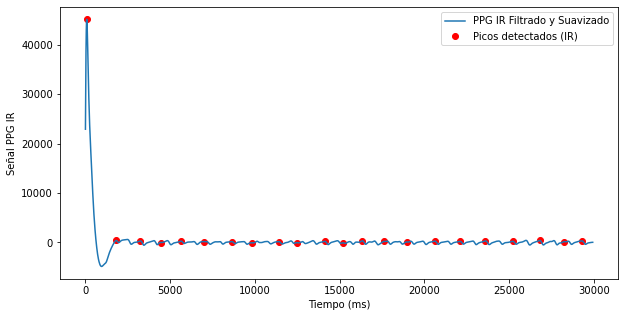

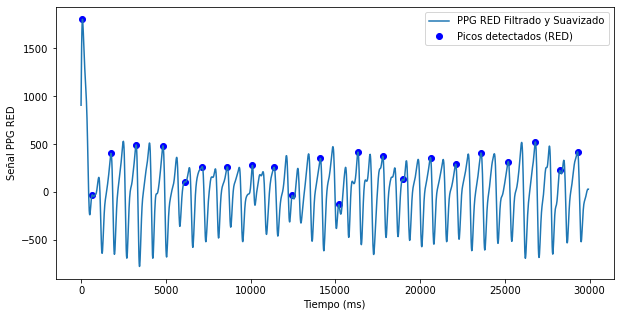

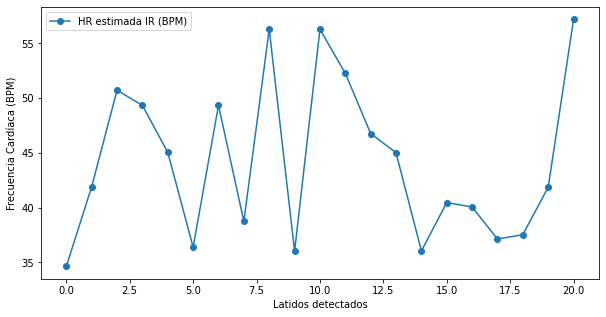

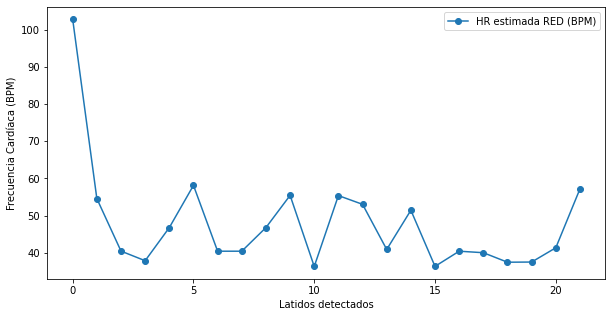

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(signal, lowcut=0.5, highcut=4.0, fs=100, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def moving_average(signal, window_size=5):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

def detect_hr_peaks(ppg_signal, time, initial_threshold=500):  # Tiempo en ms
    peaks = []
    last_peak_time = None
    threshold = initial_threshold
    hr_values = []
    
    for i in range(1, len(ppg_signal)-1):
        if ppg_signal[i-1] < ppg_signal[i] > ppg_signal[i+1]:  # Detectar pico
            if last_peak_time is None or (time[i] - last_peak_time) > threshold:
                peaks.append(i)
                if last_peak_time is not None:
                    interval = (time[i] - last_peak_time) / 1000  # Convertir a segundos
                    hr = 60 / interval  # HR en BPM
                    hr_values.append(hr)
                    
                    # Ajustar umbral dinámico para evitar sobrecompensaciones
                    threshold = max(450, min(1000, 60000 / hr))  # Entre 450ms y 1000ms
                last_peak_time = time[i]
    
    return np.array(peaks), np.array(hr_values)

# Cargar datos del CSV
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"
df = pd.read_csv(file_path, decimal='.', engine='python')
time = df.iloc[:, 0].values  # Primera columna: Tiempo en ms
ir_signal = df.iloc[:, 1].values  # Segunda columna: Señal IR
red_signal = df.iloc[:, 3].values  # Cuarta columna: Señal RED

# Filtrar señales con Butterworth
fs = 1000 / np.mean(np.diff(time))  # Frecuencia de muestreo estimada en Hz
ir_filtered = butter_bandpass_filter(ir_signal, 0.5, 4, fs)
red_filtered = butter_bandpass_filter(red_signal, 0.5, 4, fs)

# Suavizar señales
ir_smoothed = moving_average(ir_filtered)
red_smoothed = moving_average(red_filtered)

# Detectar picos y calcular HR para IR
peaks_ir, hr_values_ir = detect_hr_peaks(ir_smoothed, time[:len(ir_smoothed)])

# Detectar picos y calcular HR para RED
peaks_red, hr_values_red = detect_hr_peaks(red_smoothed, time[:len(red_smoothed)])

# Graficar resultados para IR
plt.figure(figsize=(10,5))
plt.plot(time[:len(ir_smoothed)], ir_smoothed, label='PPG IR Filtrado y Suavizado')
plt.scatter(time[peaks_ir], ir_smoothed[peaks_ir], color='red', label='Picos detectados (IR)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Señal PPG IR')
plt.legend()
plt.show()

# Graficar resultados para RED
plt.figure(figsize=(10,5))
plt.plot(time[:len(red_smoothed)], red_smoothed, label='PPG RED Filtrado y Suavizado')
plt.scatter(time[peaks_red], red_smoothed[peaks_red], color='blue', label='Picos detectados (RED)')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Señal PPG RED')
plt.legend()
plt.show()

# Mostrar HR estimada para IR
plt.figure(figsize=(10,5))
plt.plot(hr_values_ir, marker='o', linestyle='-', label='HR estimada IR (BPM)')
plt.xlabel('Latidos detectados')
plt.ylabel('Frecuencia Cardíaca (BPM)')
plt.legend()
plt.show()

# Mostrar HR estimada para RED
plt.figure(figsize=(10,5))
plt.plot(hr_values_red, marker='o', linestyle='-', label='HR estimada RED (BPM)')
plt.xlabel('Latidos detectados')
plt.ylabel('Frecuencia Cardíaca (BPM)')
plt.legend()
plt.show()

### Estimación de la frecuencia cardíaca a partir de los csv limpios

asta este punto del notebook, el procesamiento de las señales PPG se ha realizado utilizando **suavizado mediante media móvil**. Sin embargo, la media móvil tiene varias limitaciones importantes:

- **No elimina componentes de muy baja frecuencia**, como fluctuaciones lentas del nivel de base (por ejemplo, debidas a movimientos del paciente o variaciones de perfusión).
- Atenúa todas las frecuencias por igual en función del tamaño de la ventana, sin distinguir entre ruido y señal útil.

Por estas razones, en esta etapa del análisis se incorpora un **filtro paso banda Butterworth (0.7–3.3 Hz)** que está específicamente diseñado para:

- **Eliminar frecuencias fuera del rango típico de la frecuencia cardíaca** 
- **Preservar únicamente las oscilaciones correspondientes al pulso arterial**.
- **Mejorar la detección de picos** y evitar falsas detecciones o pérdidas de latidos, especialmente en registros ruidosos o de baja amplitud.

En esta celda se procesa automáticamente una carpeta con múltiples archivos CSV que contienen señales PPG (infrarroja y roja). Para cada archivo, se aplican los siguientes pasos:

1. **Estimación de la frecuencia de muestreo**  
   Se calcula automáticamente a partir de la diferencia media entre muestras de tiempo (`fs`), lo que permite adaptar el filtrado a cada caso.

2. **Filtrado paso banda (0.7 – 3.3 Hz)**  
   Se aplica un filtro Butterworth para conservar únicamente la banda de frecuencias asociada a la actividad cardíaca (≈42 – 200 latidos por minuto), eliminando ruido y otras componentes.

4. **Suavizado**  
   La señal filtrada se suaviza con una media móvil de 3 muestras para facilitar la detección de picos sin perder resolución temporal.

5. **Detección de picos**  
   Se emplea `scipy.signal.find_peaks()` con:
   - Un umbral dinámico basado en la media + 0.3 × desviación estándar de la señal suavizada.
   - Un parámetro `distance` que impone un intervalo mínimo entre picos equivalente a una FC máxima de 180 bpm.

6. **Cálculo de frecuencia cardíaca**  
   Se calcula el intervalo RR (entre picos consecutivos) y se transforma en bpm. Se filtran valores no fisiológicos (RR fuera de 0.3–2 s) y se obtiene la HR como mediana de los intervalos válidos.

7. **Resultado por archivo**  
   Se imprime para cada archivo:
   - Nombre del archivo.
   - Frecuencia cardíaca estimada por canal (IR y RED).
   - Número de picos válidos detectados.

Este enfoque permite comparar la calidad de la estimación entre diferentes registros y detectar señales poco fiables o mal colocadas.


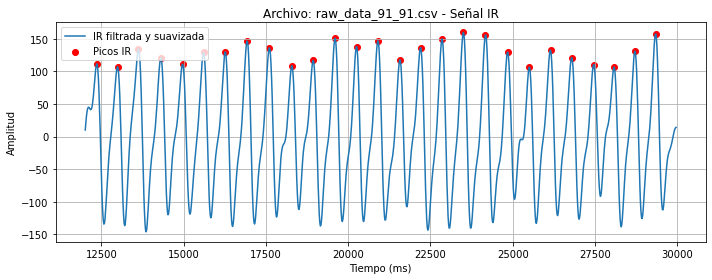

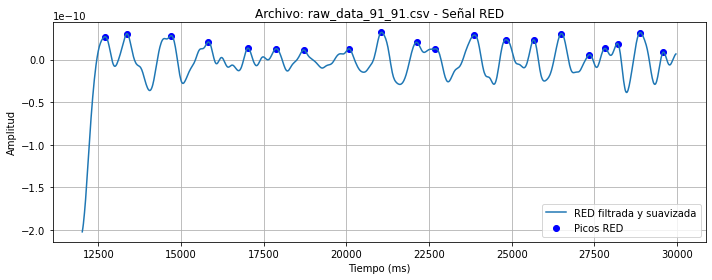

Archivo: raw_data_91_91.csv
  HR IR : 92.4 bpm  (27 picos detectados)
  HR RED: 70.6 bpm  (20 picos detectados)



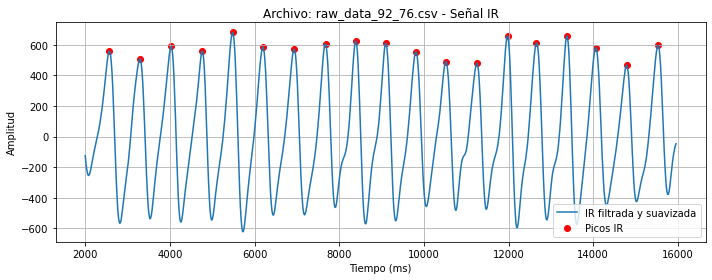

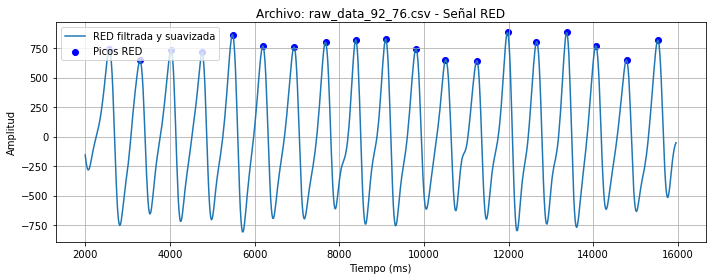

Archivo: raw_data_92_76.csv
  HR IR : 83.7 bpm  (19 picos detectados)
  HR RED: 82.9 bpm  (19 picos detectados)



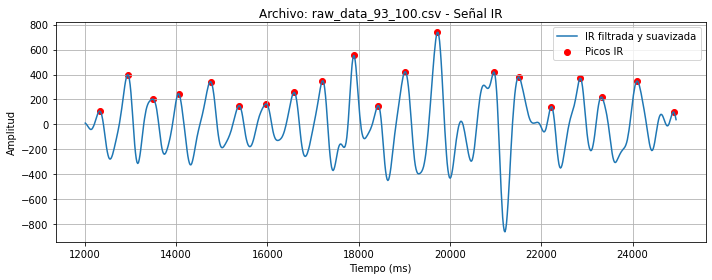

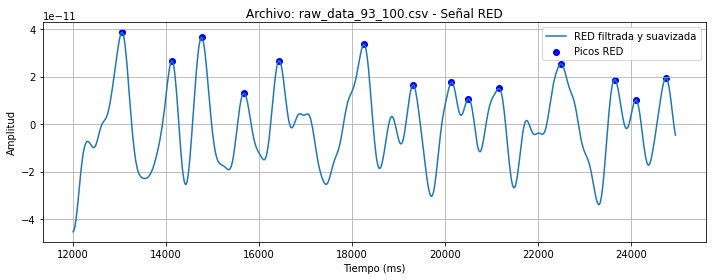

Archivo: raw_data_93_100.csv
  HR IR : 97.2 bpm  (20 picos detectados)
  HR RED: 73.5 bpm  (14 picos detectados)



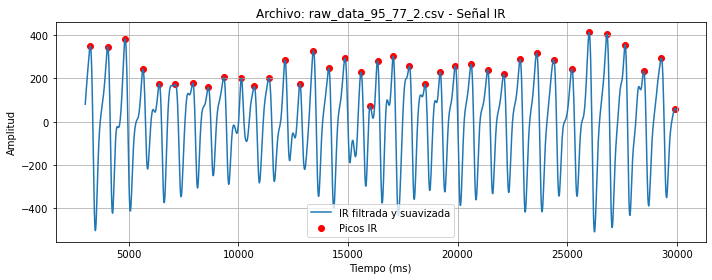

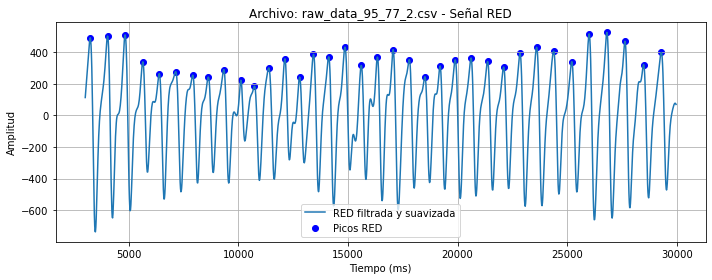

Archivo: raw_data_95_77_2.csv
  HR IR : 81.7 bpm  (38 picos detectados)
  HR RED: 80.1 bpm  (36 picos detectados)



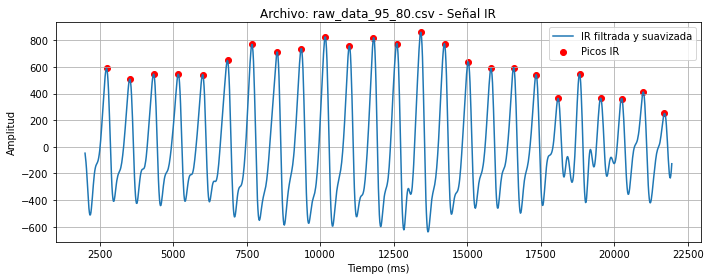

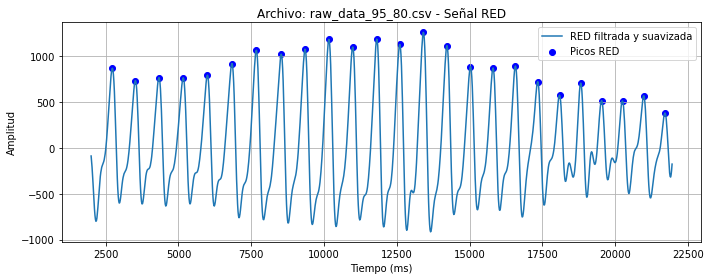

Archivo: raw_data_95_80.csv
  HR IR : 75.0 bpm  (25 picos detectados)
  HR RED: 75.0 bpm  (25 picos detectados)



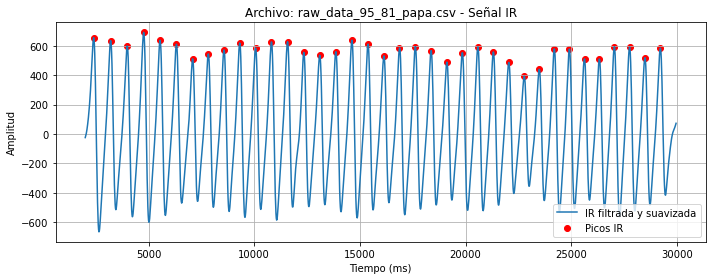

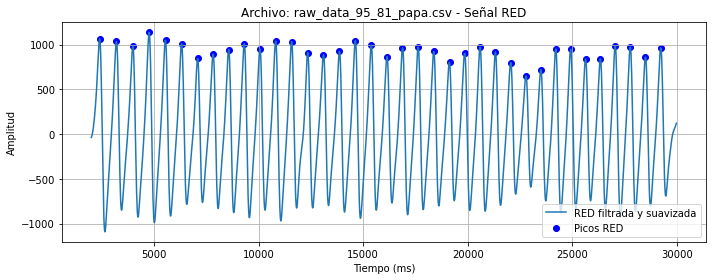

Archivo: raw_data_95_81_papa.csv
  HR IR : 80.1 bpm  (37 picos detectados)
  HR RED: 80.1 bpm  (37 picos detectados)



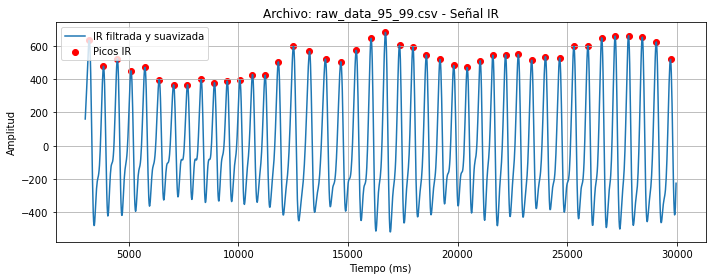

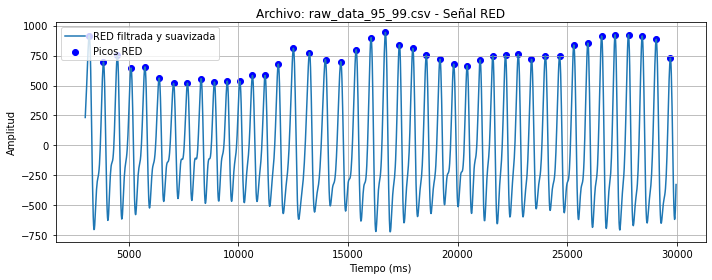

Archivo: raw_data_95_99.csv
  HR IR : 94.9 bpm  (43 picos detectados)
  HR RED: 94.9 bpm  (43 picos detectados)



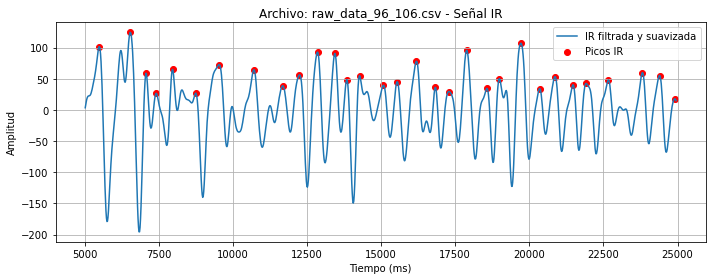

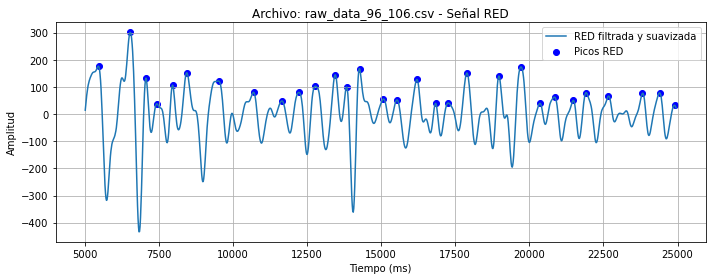

Archivo: raw_data_96_106.csv
  HR IR : 100.1 bpm  (31 picos detectados)
  HR RED: 94.9 bpm  (30 picos detectados)



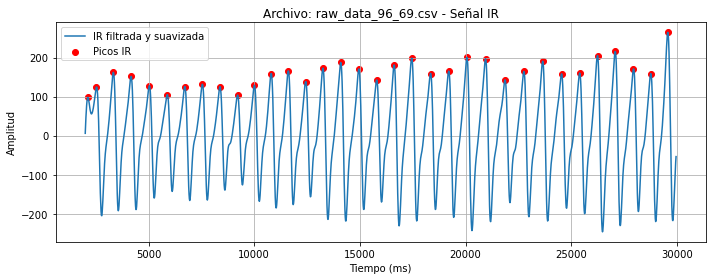

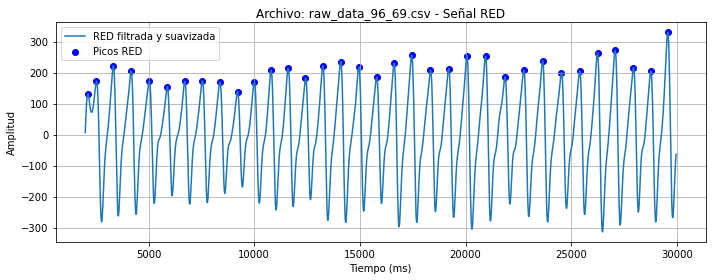

Archivo: raw_data_96_69.csv
  HR IR : 72.0 bpm  (34 picos detectados)
  HR RED: 72.0 bpm  (34 picos detectados)



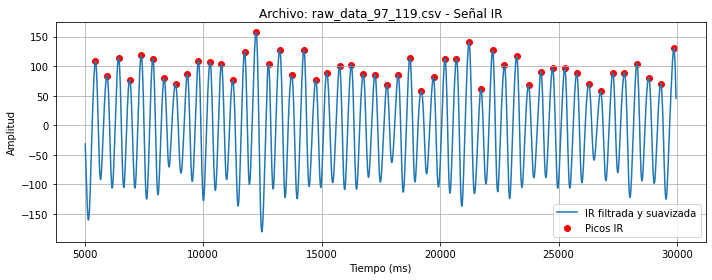

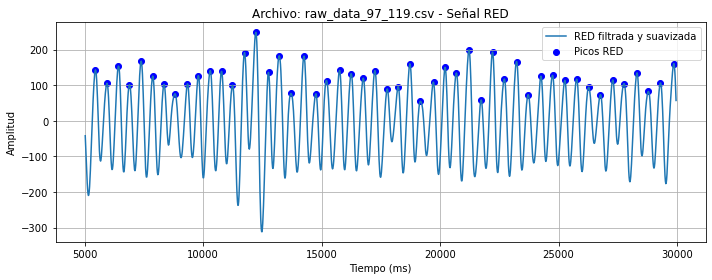

Archivo: raw_data_97_119.csv
  HR IR : 120.0 bpm  (50 picos detectados)
  HR RED: 120.2 bpm  (50 picos detectados)



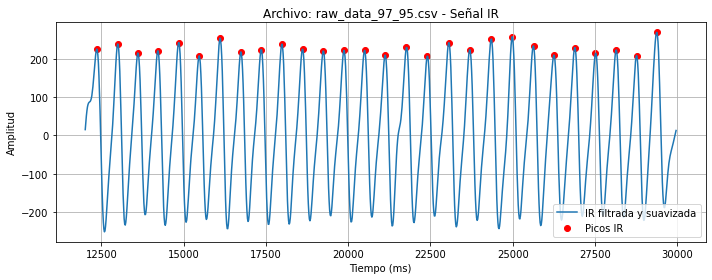

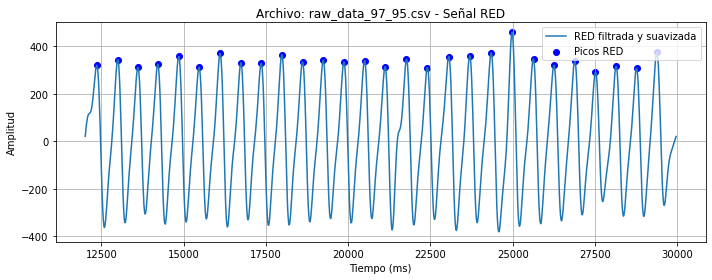

Archivo: raw_data_97_95.csv
  HR IR : 94.9 bpm  (28 picos detectados)
  HR RED: 94.9 bpm  (28 picos detectados)



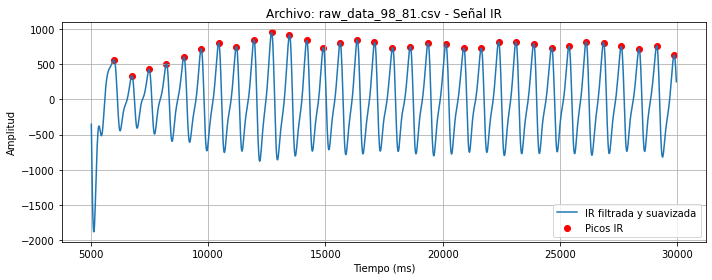

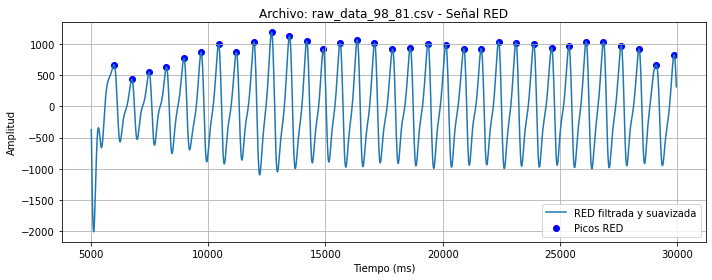

Archivo: raw_data_98_81.csv
  HR IR : 80.1 bpm  (33 picos detectados)
  HR RED: 80.1 bpm  (33 picos detectados)



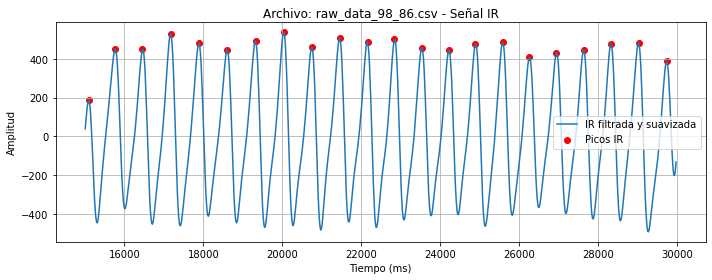

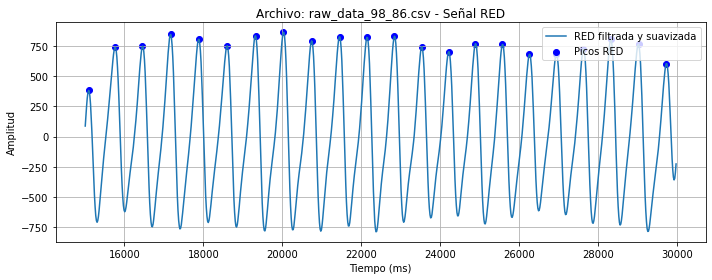

Archivo: raw_data_98_86.csv
  HR IR : 85.7 bpm  (22 picos detectados)
  HR RED: 85.8 bpm  (22 picos detectados)



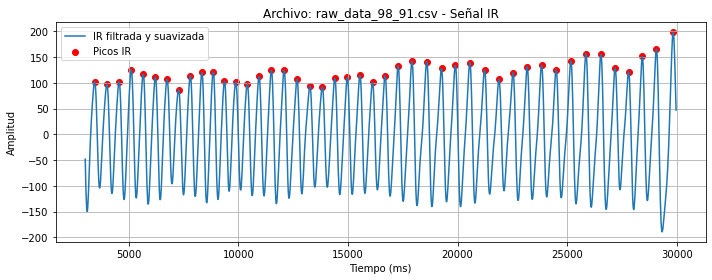

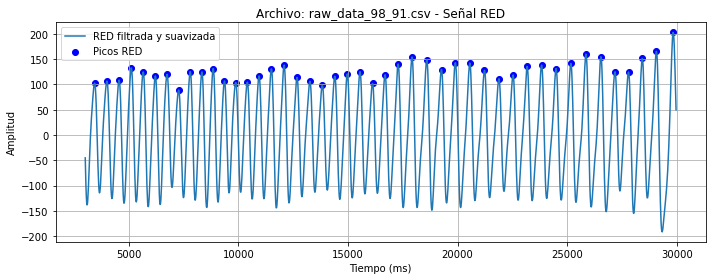

Archivo: raw_data_98_91.csv
  HR IR : 102.9 bpm  (45 picos detectados)
  HR RED: 102.9 bpm  (45 picos detectados)



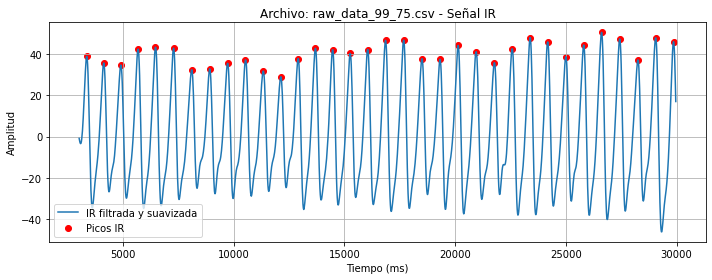

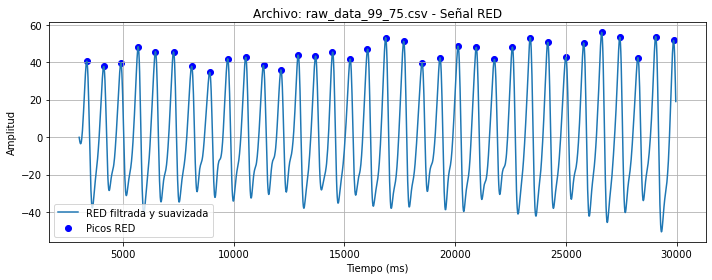

Archivo: raw_data_99_75.csv
  HR IR : 75.0 bpm  (34 picos detectados)
  HR RED: 73.5 bpm  (34 picos detectados)



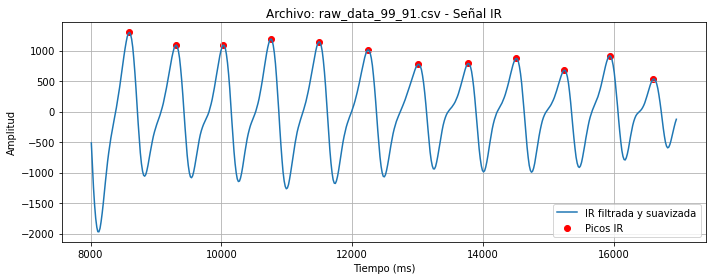

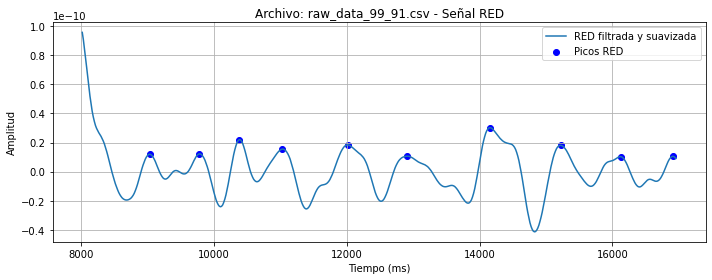

Archivo: raw_data_99_91.csv
  HR IR : 81.9 bpm  (12 picos detectados)
  HR RED: 66.7 bpm  (10 picos detectados)



In [11]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# --- Funciones auxiliares ---
def butter_bandpass_filter(signal, lowcut=0.7, highcut=3.3, fs=100, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def moving_average(signal, window_size=3):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# --- Procesar todos los CSV ---
folder = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"
csv_paths = glob.glob(os.path.join(folder, "*.csv"))

for csv_path in csv_paths:
    df = pd.read_csv(csv_path, decimal='.', engine='python')
    time = df.iloc[:, 0].values  # Tiempo en ms
    ir_signal = df.iloc[:, 1].values  # Señal IR
    red_signal = df.iloc[:, 3].values  # Señal RED

    # Frecuencia de muestreo estimada
    fs = 1000 / np.mean(np.diff(time))

    # Filtro paso banda y suavizado
    ir_f = butter_bandpass_filter(ir_signal, 0.7, 3.3, fs)
    red_f = butter_bandpass_filter(red_signal, 0.7, 3.3, fs)
    ir_s = moving_average(ir_f, window_size=3)
    red_s = moving_average(red_f, window_size=3)
    t_s = time[:len(ir_s)]

    # Umbral y distancia mínima
    thr_ir = ir_s.mean() + 0.3 * ir_s.std()
    thr_red = red_s.mean() + 0.3 * red_s.std()
    min_dist = int(fs * (60 / 180))  # mínimo intervalo entre picos

    peaks_ir, _ = find_peaks(ir_s, height=thr_ir, distance=min_dist)
    peaks_red, _ = find_peaks(red_s, height=thr_red, distance=min_dist)

    # Cálculo de FC
    def calc_hr(peaks, t):
        if len(peaks) >= 5:
            rr = np.diff(t[peaks]) / 1000
            rr = rr[(rr > 0.3) & (rr < 2)]
            if len(rr) > 0:
                return 60 / np.median(rr), len(peaks)
        return np.nan, len(peaks)

    hr_ir, n_ir = calc_hr(peaks_ir, t_s)
    hr_red, n_red = calc_hr(peaks_red, t_s)
    
    # Graficar señal IR filtrada y picos
    plt.figure(figsize=(10, 4))
    plt.plot(t_s, ir_s, label='IR filtrada y suavizada')
    plt.scatter(t_s[peaks_ir], ir_s[peaks_ir], color='red', label='Picos IR')
    plt.title(f"Archivo: {os.path.basename(csv_path)} - Señal IR")
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Graficar señal RED filtrada y picos
    plt.figure(figsize=(10, 4))
    plt.plot(t_s, red_s, label='RED filtrada y suavizada')
    plt.scatter(t_s[peaks_red], red_s[peaks_red], color='blue', label='Picos RED')
    plt.title(f"Archivo: {os.path.basename(csv_path)} - Señal RED")
    plt.xlabel("Tiempo (ms)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Resultados
    print(f"Archivo: {os.path.basename(csv_path)}")
    print(f"  HR IR : {hr_ir:.1f} bpm  ({n_ir} picos detectados)")
    print(f"  HR RED: {hr_red:.1f} bpm  ({n_red} picos detectados)\n")
